<h1> Gradient Decent Revisit with Pytorch</h1> <br>
<img src="../data/Linear_Regression.gif" width="1200" align="center">
Animation of our "model" at each step when training with gradient descent

<b>With our new knowledge of Pytorch let's create a new implementation of gradient decent!</b>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

<h3> Loading the data </h3>
Lets load some "toy" data that we can use

In [2]:
# You can load your data using this cell
npzfile = np.load("../data/toy_data_two_moon.npz") # toy_data.npz or toy_data_two_circles.npz

# The compressed Numpy file is split up into 4 parts
# Lets convert them to Pytorch Float Tensors
# Train inputs and target outputs
x_train = torch.FloatTensor(npzfile['arr_0'])
y_train = torch.FloatTensor(npzfile['arr_2'])

# Test inputs and target outputs
x_test = torch.FloatTensor(npzfile['arr_1'])
y_test = torch.FloatTensor(npzfile['arr_3'])

<h3> Let's plot our data </h3>

Text(0.5, 1.0, 'Test data')

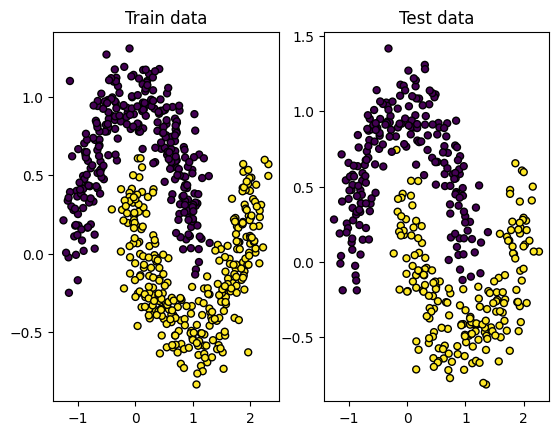

In [3]:
# Lets see what the data looks like
plt.subplot(121)
plt.scatter(x_train[:, 0], x_train[:, 1], marker='o', c=y_train[:,0], s=25, edgecolor='k')
plt.title("Train data")
plt.subplot(122)
plt.scatter(x_test[:, 0], x_test[:, 1], marker='o', c=y_test[:,0], s=25, edgecolor='k')
plt.title("Test data")

Our data is randomly sampled from an odd looking distribution, the colour of the dots (as represented by y_test[:,0], a one or zero) is what the output of our model SHOULD be (aka the "Ground Truth Data"). Note that each data point is a vector of two values (the "x and y" values), therefore there will only be two parameters in our linear model. <br>
<b>Note we do NOT need to add ones to our data for a bias term as Pytorch's Linear layer has a bias term by default</b>

<h2>Training a model with GD </h2>

[Gradient Descent, Step-by-Step by StatQuest](https://youtu.be/sDv4f4s2SB8?si=iClqYh2v3I7uf9WR)

In doing so, we need a function to <br>
1- compute the loss with respect to the inputs and the parameters of the model <br>
2- compute the gradient of the model with respect to its parameters $\theta$

We recall the loss of the linear regression as
\begin{align}
L(\theta) = \frac{1}{m} \sum_{i=1}^m \|\theta^\top \boldsymbol{x}_i - y_i\|^2
\end{align}

Now it is easy to see that

\begin{align}
\frac{\partial L}{\partial \theta} = \frac{1}{m} \sum_{i=1}^m 2(\theta^\top \boldsymbol{x}_i - y_i)\boldsymbol{x}_i
\end{align}

Instead of calculating the gradient by hand, we'll just use Pytorch's auto-grad!!

In [4]:
# Define our linear model - 2 inputs, 1 output (bias is included in linear layer)
linear = nn.Linear(2, 1) # To Do
# Define our loss function - MSE
loss_function = nn.MSELoss() # To Do
# Create our GD optimizer - lr = 0.1
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1) # To Do

With this, we can perform multiple iterations of GD to train the model

In [5]:
# Number of times we iterate over the dataset
max_epoch = 100

loss_log = [] # keep track of the loss values
acc = [] # keep track of the accuracy 
for epoch in range(max_epoch):
    
    # Perform a test set accuracy calculation
    with torch.no_grad():
        y_test_hat = linear(x_test) # To Do
        class_pred = (y_test_hat >= 0.5).to(float) # To Do
        acc.append( torch.sum( y_test == class_pred ) / len(y_test) ) # To Do)
    
    # Perform a training step
    
    # Forward pass
    y_train_hat = linear(x_train) # To Do
            
    # Calculate loss
    loss = loss_function(y_train_hat, y_train) # To Do
    
    # Zero the gradient
    # To Do
    optimizer.zero_grad()
    # Perform backprop
    # To Do
    loss.backward()
    # Perform optimization step
    # To Do
    optimizer.step()
    # Append loss
    loss_log.append( loss.item() ) # To Do)
    
print("Accuracy of linear model(GD): %.2f%% " %(acc[-1]*100))

Accuracy of linear model(GD): 88.25% 


Text(0, 0.5, 'Accuracy')

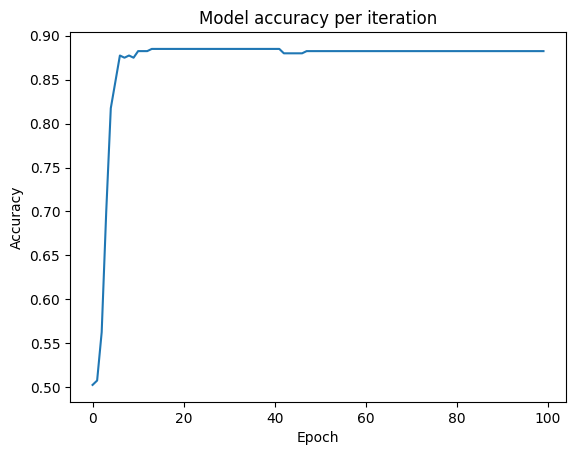

In [6]:
plt.plot(acc)
plt.title("Model accuracy per iteration")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'MSE Loss')

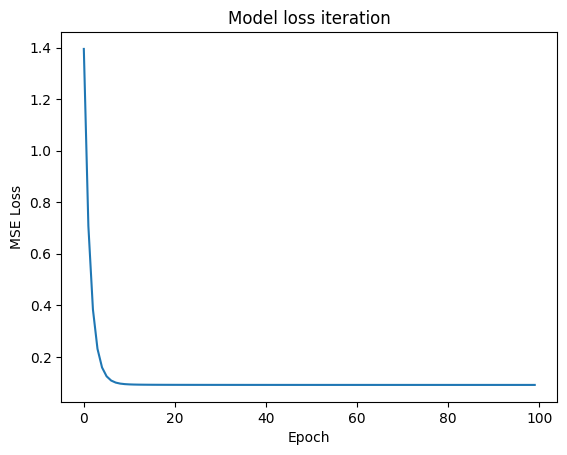

In [7]:
plt.plot(loss_log)
plt.title("Model loss iteration")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

<h1>Logistic Regression </h1>
We can see that with binary classification our goal is possition the decision boundary such that it seperates the two classes. However by simply using linear regression with binary labels, we are forcing our model to try and position the decision boundary at a fixed distance from each data point, EVEN if it's on the "correct" side of the boundary. For example if a data point (label 1) was on the correct side of the boundary (positive side)
BUT it was a large distance away from the boundary, the model would be penalised and the boundary would be moved. This is an obvious problem if there is a large spread of values for a given class and can lead to our model to never converge to an optimal solution. <br>

<h3>Sigmoid</h3>
<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg" width="300" align="center">

Instead we think about moving the descision boundary *as far as possible* from the positive points on one side and *as far as possible* from the negative points on the other side. To do this we can utilize the Sigmoid function, which maps all real numbers to the range 0 to 1: $$ R \to [0, 1] $$ <br>
By putting the Sigmoid function on the output of our model we can see that to reach the target value 1, the raw model ouput would have to be $+\infty$ and 0 would be $-\infty$. The optimal solution would therefore achieve our goal of maximising the distance between the data points and the descision boundary.<br>
While this solves one problem, it introduces another, the sigmoid function's gradient (derivative) is very flat for values witha large magnitude. If we were to use the MSE loss to train a model with a Sigmoid on the output, training would not only be slow, but may not progress at all! To see why, consider the case where our model as made a very large incorrect prediction, the gradient in this case would be very very small, the update to our model would therefore also be very small. <br>
To convince yourself of this try adding the sigmoid function (torch.sigmoid()) to the output of the above model and train!

<h3>Cross-Entropy loss</h3>
We therefore introduce a new loss function the <a href="https://en.wikipedia.org/wiki/Cross-entropy#Cross-entropy_loss_function_and_logistic_regression">Cross-Entropy loss</a>:

\begin{align}
L(\hat y, y) &= -y\ln (\hat y) - (1 - y)\ln (1 - \hat y)\\
\\
Where&\\
y &= Target \: value\\
\hat y &= Predicted \: value\\
\end{align}

We obtain this loss from the maximum log-likelihood of a multinomial (or binomial in the binary case) distribution. That is, instead of simply regressing to a value, we our model is now produces a probability distribution for the likelihood that a given input belongs to a given class. For the single output binary logistic case we get a single probability that the input belongs the the possitive (1) class. <br>
NOTE that using a Softmax output (rather than Sigmoid) with a Cross-Entropy loss is very common for multiclass classification but can also be used for binary classification (more on this later).

<h3>It's still a linear model!</h3>
It's important to realise that even though our model now has the non-linear Sigmoid function on it's output, this model is still only linear, an therefore can only produce a linear descision boundary! We've simply changed that way we think about our model and how we train it!

<h2>Create a Logistic Regression Model</h2>

In [8]:
# Define our linear model - 2 inputs, 1 output (bias is included in linear layer)
logistic_linear = nn.Linear(2, 1) # To Do

# Define our loss function - Binary Cross entropy With logits
# By using the "with logits" version Pytorch will assume the outputs given are the RAW
# model outputs without the Sigmoid (logits - log odd probabilities, it is the inverse of the sigmoid function!)
# Pytorch incorporates the Sigmoid into the loss function for numerical stability!
loss_function = nn.BCEWithLogitsLoss() # To Do

# Create our optimizer - lr = 0.1
logistic_optimizer = torch.optim.SGD(logistic_linear.parameters(), lr=0.1) # To Do

In [9]:
# Number of times we iterate over the dataset
max_epoch = 100

logistic_loss_log = [] # keep track of the loss values
logistic_acc = [] # keep track of the accuracy 
for epoch in range(max_epoch):
    # Perform a test set accuracy calculation
    with torch.no_grad():
        y_test_hat = logistic_linear(x_test) # To Do
        class_pred = (y_test_hat > 0).float() # To Do
        logistic_acc.append( float(sum( class_pred == y_test ) / len(y_test)) ) # To Do)

    # Perform a training step
    
    # Forward pass
    y_train_hat = logistic_linear(x_train) # To Do
            
    # Calculate loss
    loss = loss_function(y_train_hat, y_train) # To Do
    
    # Zero the gradient
    # To Do
    logistic_optimizer.zero_grad()
    # Perform backprop
    # To Do
    loss.backward()
    # Perform optimization step
    # To Do
    logistic_optimizer.step()
    # Append loss
    logistic_loss_log.append( loss.item() ) # To Do)
    
print("Accuracy of linear model(GD): %.2f%% " %(acc[-1]*100))

Accuracy of linear model(GD): 88.25% 


Text(0.5, 0, 'Accuracy')

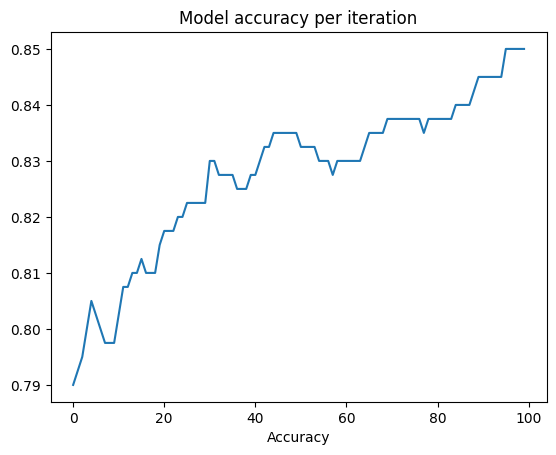

In [10]:
plt.plot(logistic_acc)
plt.title("Model accuracy per iteration")
plt.xlabel("Epoch")
plt.xlabel("Accuracy")

Text(0.5, 0, 'BCE Loss')

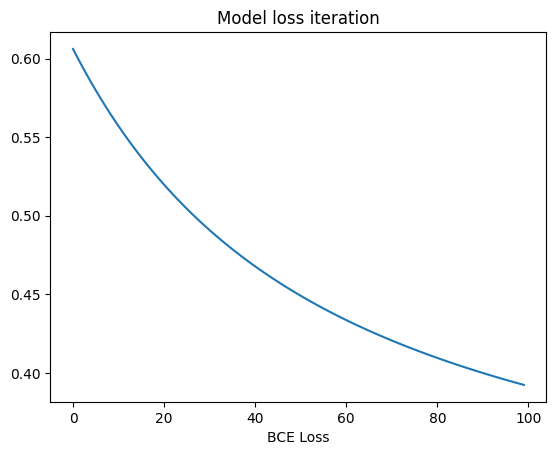

In [11]:
plt.plot(logistic_loss_log)
plt.title("Model loss iteration")
plt.xlabel("Epoch")
plt.xlabel("BCE Loss")